In [1]:
library(extrafont)
library(tidyverse)
library(epidemia)
library(arrow)
library(zoo)

Registering fonts with R

── Attaching core tidyverse packages ───────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




# 1. parameters

In [2]:
T0 = 40

## observation parameters

In [3]:
alpha = 0.01

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [4]:
K = 6.5

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

$$I_{-T_0} = \mu_0$$

# 2. load data

In [5]:
data <- read_feather('data/CovidCastStateAdj_2.feather')

In [6]:
data = (data 
        %>% transmute(
            region = geo_value,
            date = date(time_value),
            deaths = as.integer(pmax(data$deaths, 0)),
            intervention = full_time_work_prop) 
        %>% group_by(region)
        %>% filter(max(deaths) > 20)
        %>% filter(date > date[which(cumsum(deaths) > 10)[1]] - 30))

In [7]:
data = data %>% mutate(iv_ma7 = rollmean(x = intervention, 7, fill=NA))

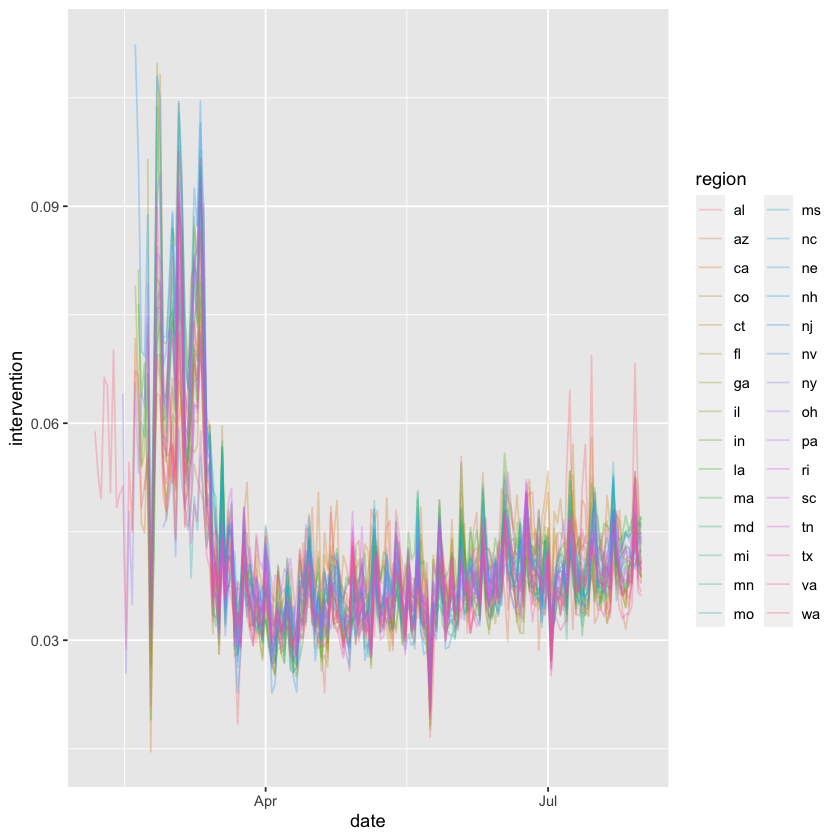

In [ ]:
ggplot(data) + geom_line(aes(date, intervention, group = region, color = region), alpha = 0.3) 

Warning message:
“Removed 180 rows containing missing values (`geom_line()`).”


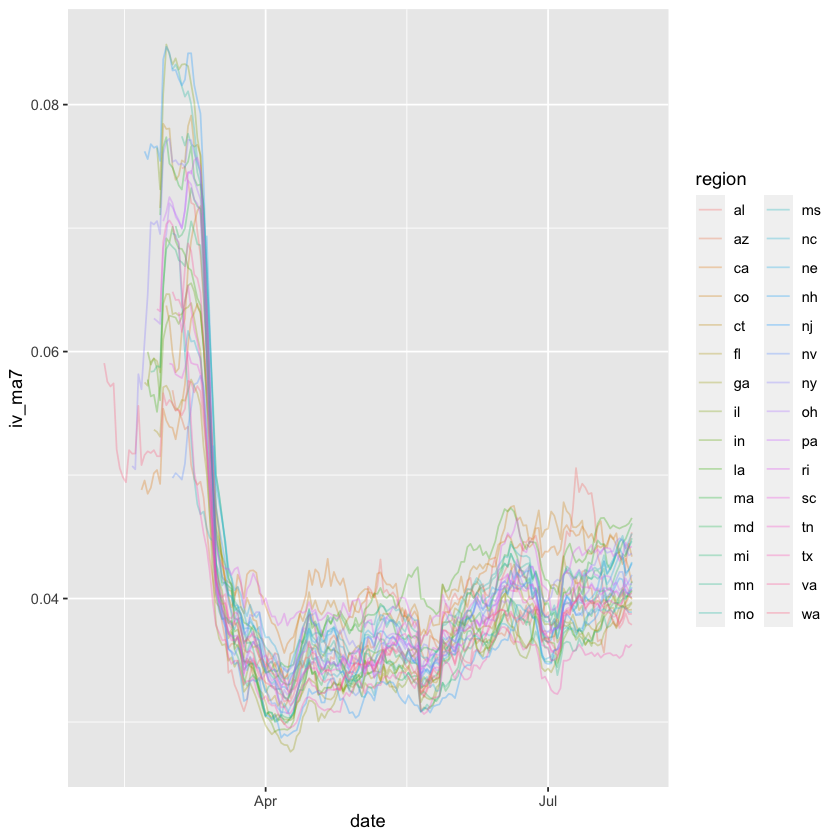

In [9]:
ggplot(data) + geom_line(aes(date, iv_ma7, group = region, color = region), alpha = 0.3) 

In [40]:
data = data %>% group_modify(~ {
    data.frame(date = c(min(.x$date)+(-T0:-1), .x$date),
               deaths = c(rep(NA,T0), .x$deaths),
               intervention = c(rep(0,T0), .x$intervention * (-20) + 1.6))}
)

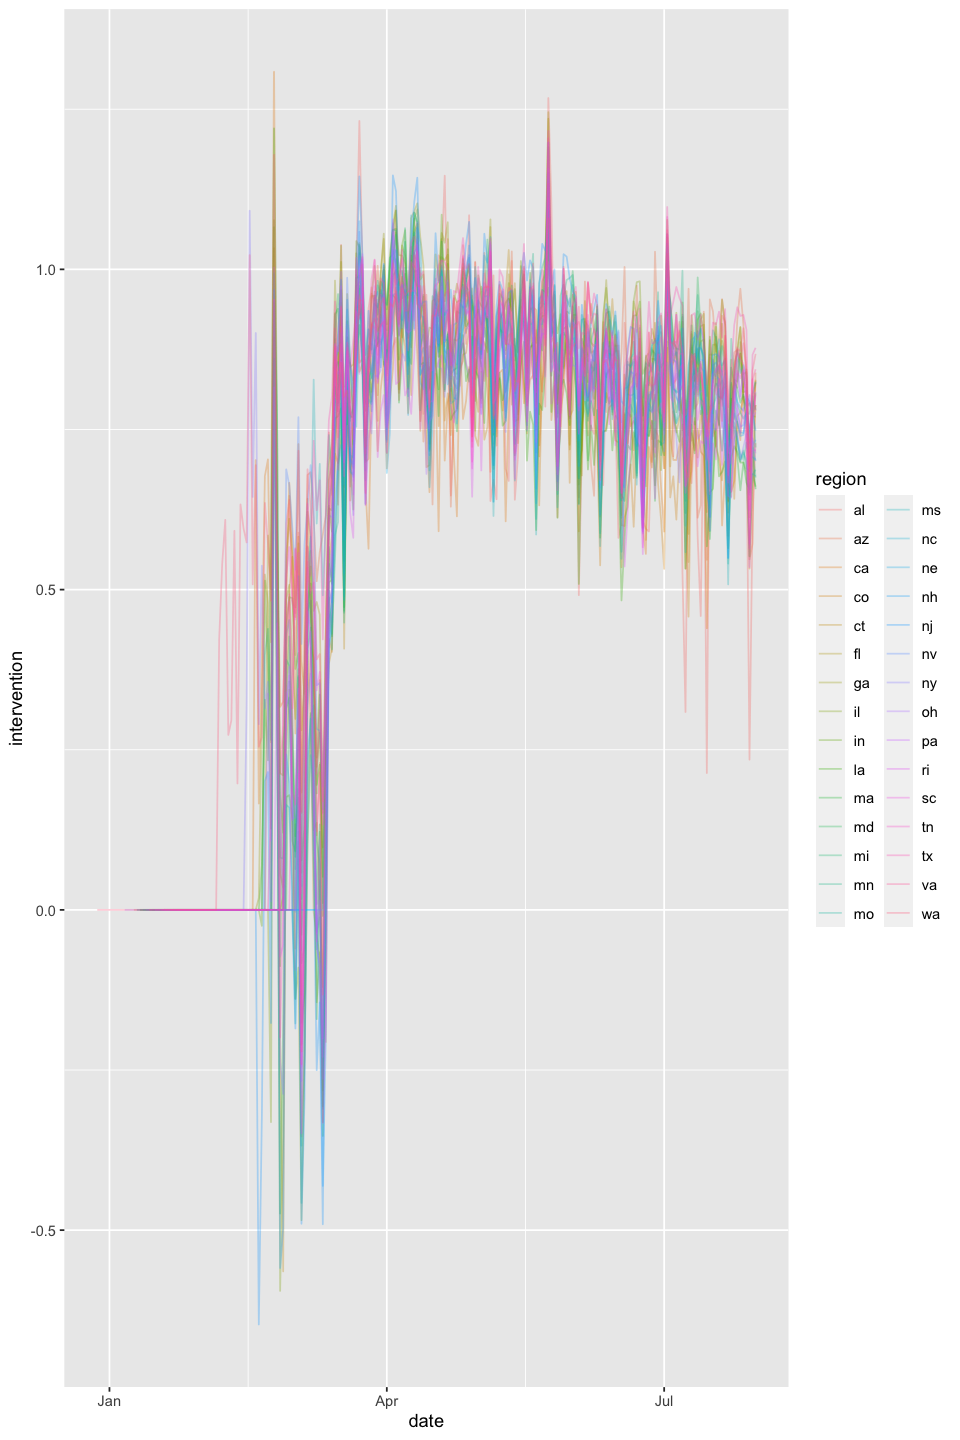

In [41]:
ggplot(data) + geom_line(aes(date, intervention, group = region, color = region), alpha = 0.3) 

# 3. fit

In [42]:
rt <- epirt(formula = R(region, date) ~ (1 + intervention || region)
            + 1 + intervention,
            prior_intercept = normal(0, 4),
            prior = normal(0, 4),
            prior_covariance = decov(shape = c(1, 1), scale = 8),
            link = scaled_logit(K))

In [43]:
# rt <- epirt(formula = R(region, date) ~ 1 + intervention
#             + (1 + intervention || region),
#             prior = normal(0, 5),
#             prior_intercept = normal(0, 8),
#             prior_covariance = decov(shape = c(1, 5), scale = 1),
#             link = scaled_logit(K))

In [44]:
# rt <- epirt(formula = R(region, date) ~ 0 +
#             + (1 + intervention || region)
#             + intervention,
#             prior = shifted_gamma(shape = 1/6, scale = 1, shift = log(1.05)/6),
#             prior_covariance = decov(shape = c(2, 0.5), scale = 1),
#             link = scaled_logit(K))

In [45]:
inf <- epiinf(gen = EuropeCovid$si, seed_days = T0)

In [46]:
deaths <- epiobs(formula = deaths ~ 1, i2o = EuropeCovid2$inf2death,
                 prior_intercept = normal(0, 0.01), link = scaled_logit(2*alpha))

Warning message:
“i2o does not sum to one. Please ensure this is intentional.”


In [47]:
args <- list(rt = rt, inf = inf, obs = deaths, data = data, 
             seed=12345, refresh=0)

In [48]:
args$algorithm <- "fullrank"; args$iter <- 5e4; args$tol_rel_obj <- 1e-3

In [49]:
fm <- do.call(epim, args)

Warning message:
“Pareto k diagnostic value is 8. Resampling is disabled. Decreasing tol_rel_obj may help if variational algorithm has terminated prematurely. Otherwise consider using sampling instead.”


In [50]:
as.data.frame(fm$stanfit)

R|(Intercept),R|intervention,R|b[(Intercept) region:al],R|b[(Intercept) region:az],R|b[(Intercept) region:ca],R|b[(Intercept) region:co],R|b[(Intercept) region:ct],R|b[(Intercept) region:fl],R|b[(Intercept) region:ga],R|b[(Intercept) region:il],⋯,seeds[pa],seeds[ri],seeds[sc],seeds[tn],seeds[tx],seeds[va],seeds[wa],seeds_aux,deaths|reciprocal dispersion,log-posterior
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.024090,-4.37351,-0.1061740,0.03402720,-0.04372120,-0.2565680,-0.10466000,-0.03164210,-6.55884e-02,-0.041723400,⋯,45.9813,37.8115,11.61140,16.7074,15.35970,30.6918,1.757620,26.06820,10.0230,0
1.730510,-4.04973,-0.1133110,0.09451020,-0.06761200,-0.1594330,-0.02590460,0.07618890,9.65984e-02,0.016199000,⋯,68.5370,55.4882,13.74540,17.9495,17.11560,30.7639,2.384670,72.35020,10.0053,0
1.304670,-3.36067,-0.1471040,0.00536830,-0.05485180,-0.0556166,-0.02132250,0.00622925,1.87550e-02,0.110576000,⋯,84.0529,59.3516,14.97780,22.0127,19.28310,45.9148,5.369560,66.92610,10.0026,0
1.774510,-4.12567,-0.0823922,0.02971970,-0.09974900,-0.0480754,0.04129500,0.13614600,2.98217e-02,-0.001513520,⋯,59.8595,47.5039,14.54580,13.8705,14.33180,31.0778,2.365120,96.38200,10.0013,0
1.444790,-3.56350,-0.1128170,-0.03512660,-0.13581200,-0.1650540,0.03430670,0.04025720,6.47493e-03,-0.025263600,⋯,83.8702,53.7303,21.09660,21.7105,17.17900,55.0343,5.063130,94.10250,10.0069,0
2.310090,-4.78678,-0.0379826,0.05339550,-0.07554570,-0.1293520,-0.08955180,0.06766400,1.50593e-01,0.083927800,⋯,44.3413,37.4546,10.55200,16.6741,9.62897,23.9529,1.194330,15.59830,10.0010,0
1.319520,-3.35600,-0.1505200,0.07623420,-0.07538290,-0.1637640,-0.04430290,0.08365800,9.70328e-02,0.013261000,⋯,96.3684,76.2664,18.89990,27.5136,20.61040,49.5103,5.598690,66.64200,10.0009,0
1.217310,-3.22605,-0.1507110,0.10051700,-0.15487600,-0.2157990,-0.01122600,0.05180400,-8.13987e-02,-0.029784200,⋯,94.0882,64.9639,15.30380,26.5873,19.60980,64.7300,8.156910,167.78700,10.0019,0
1.166310,-3.17410,-0.0499648,-0.04154810,-0.07348180,-0.1762480,0.02446590,0.05163120,-6.91490e-02,-0.041375200,⋯,97.3734,68.0593,18.36830,30.2203,24.51380,51.9244,10.809400,77.54040,10.0071,0


In [51]:
# write_feather(as.data.frame(fm$stanfit),
#               'result_epidemia_delphi_normal_4.feather')

## plots

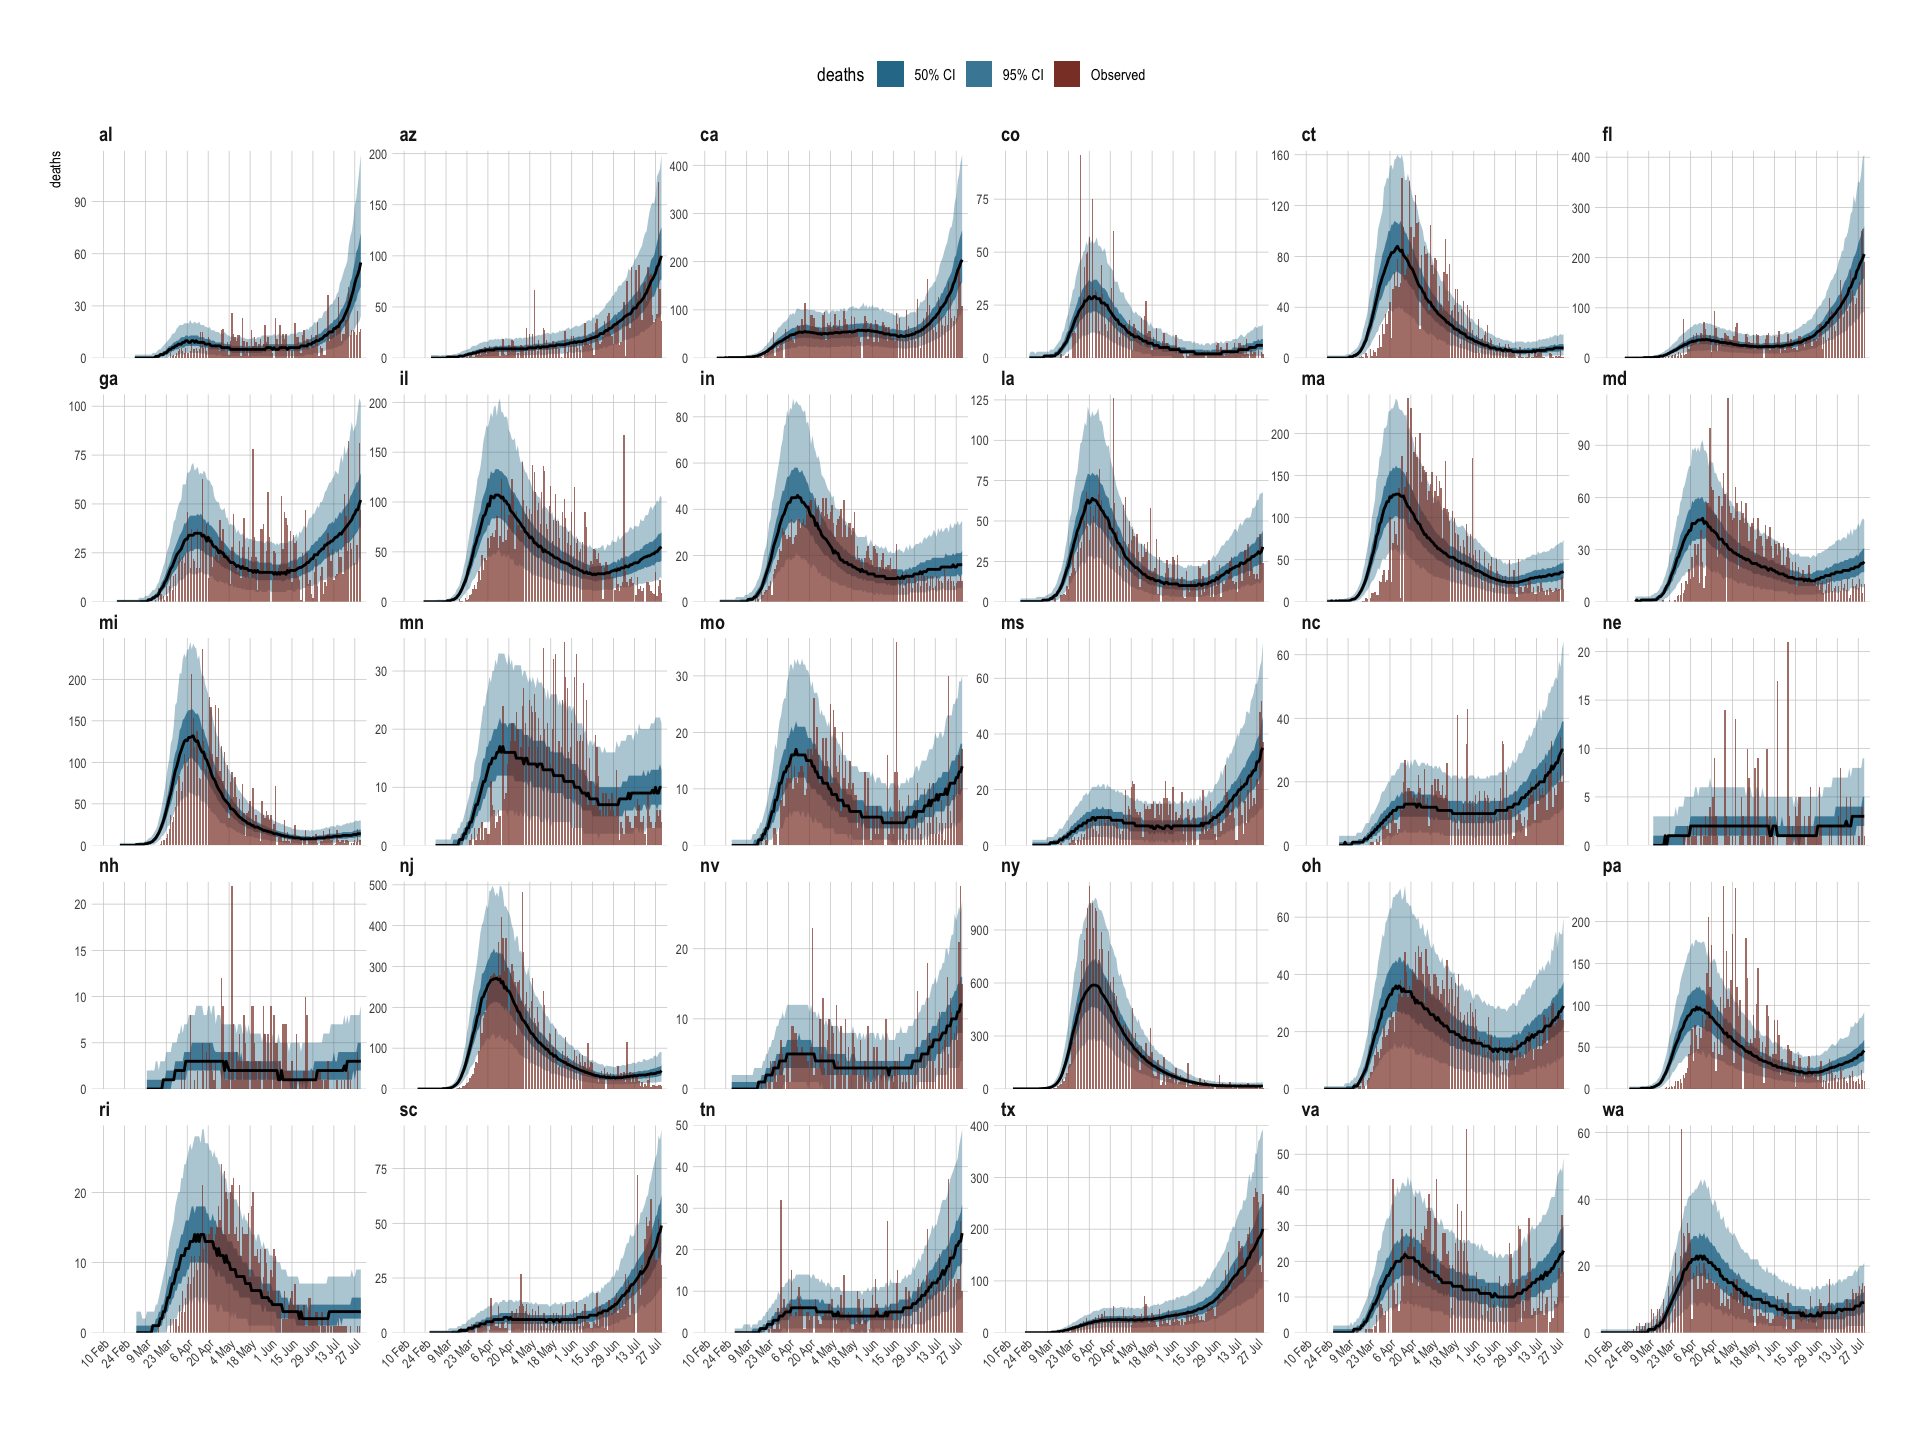

In [52]:
options(repr.plot.width = 16, repr.plot.height = 12)
plot_obs(fm, type="deaths", levels = c(50, 95))

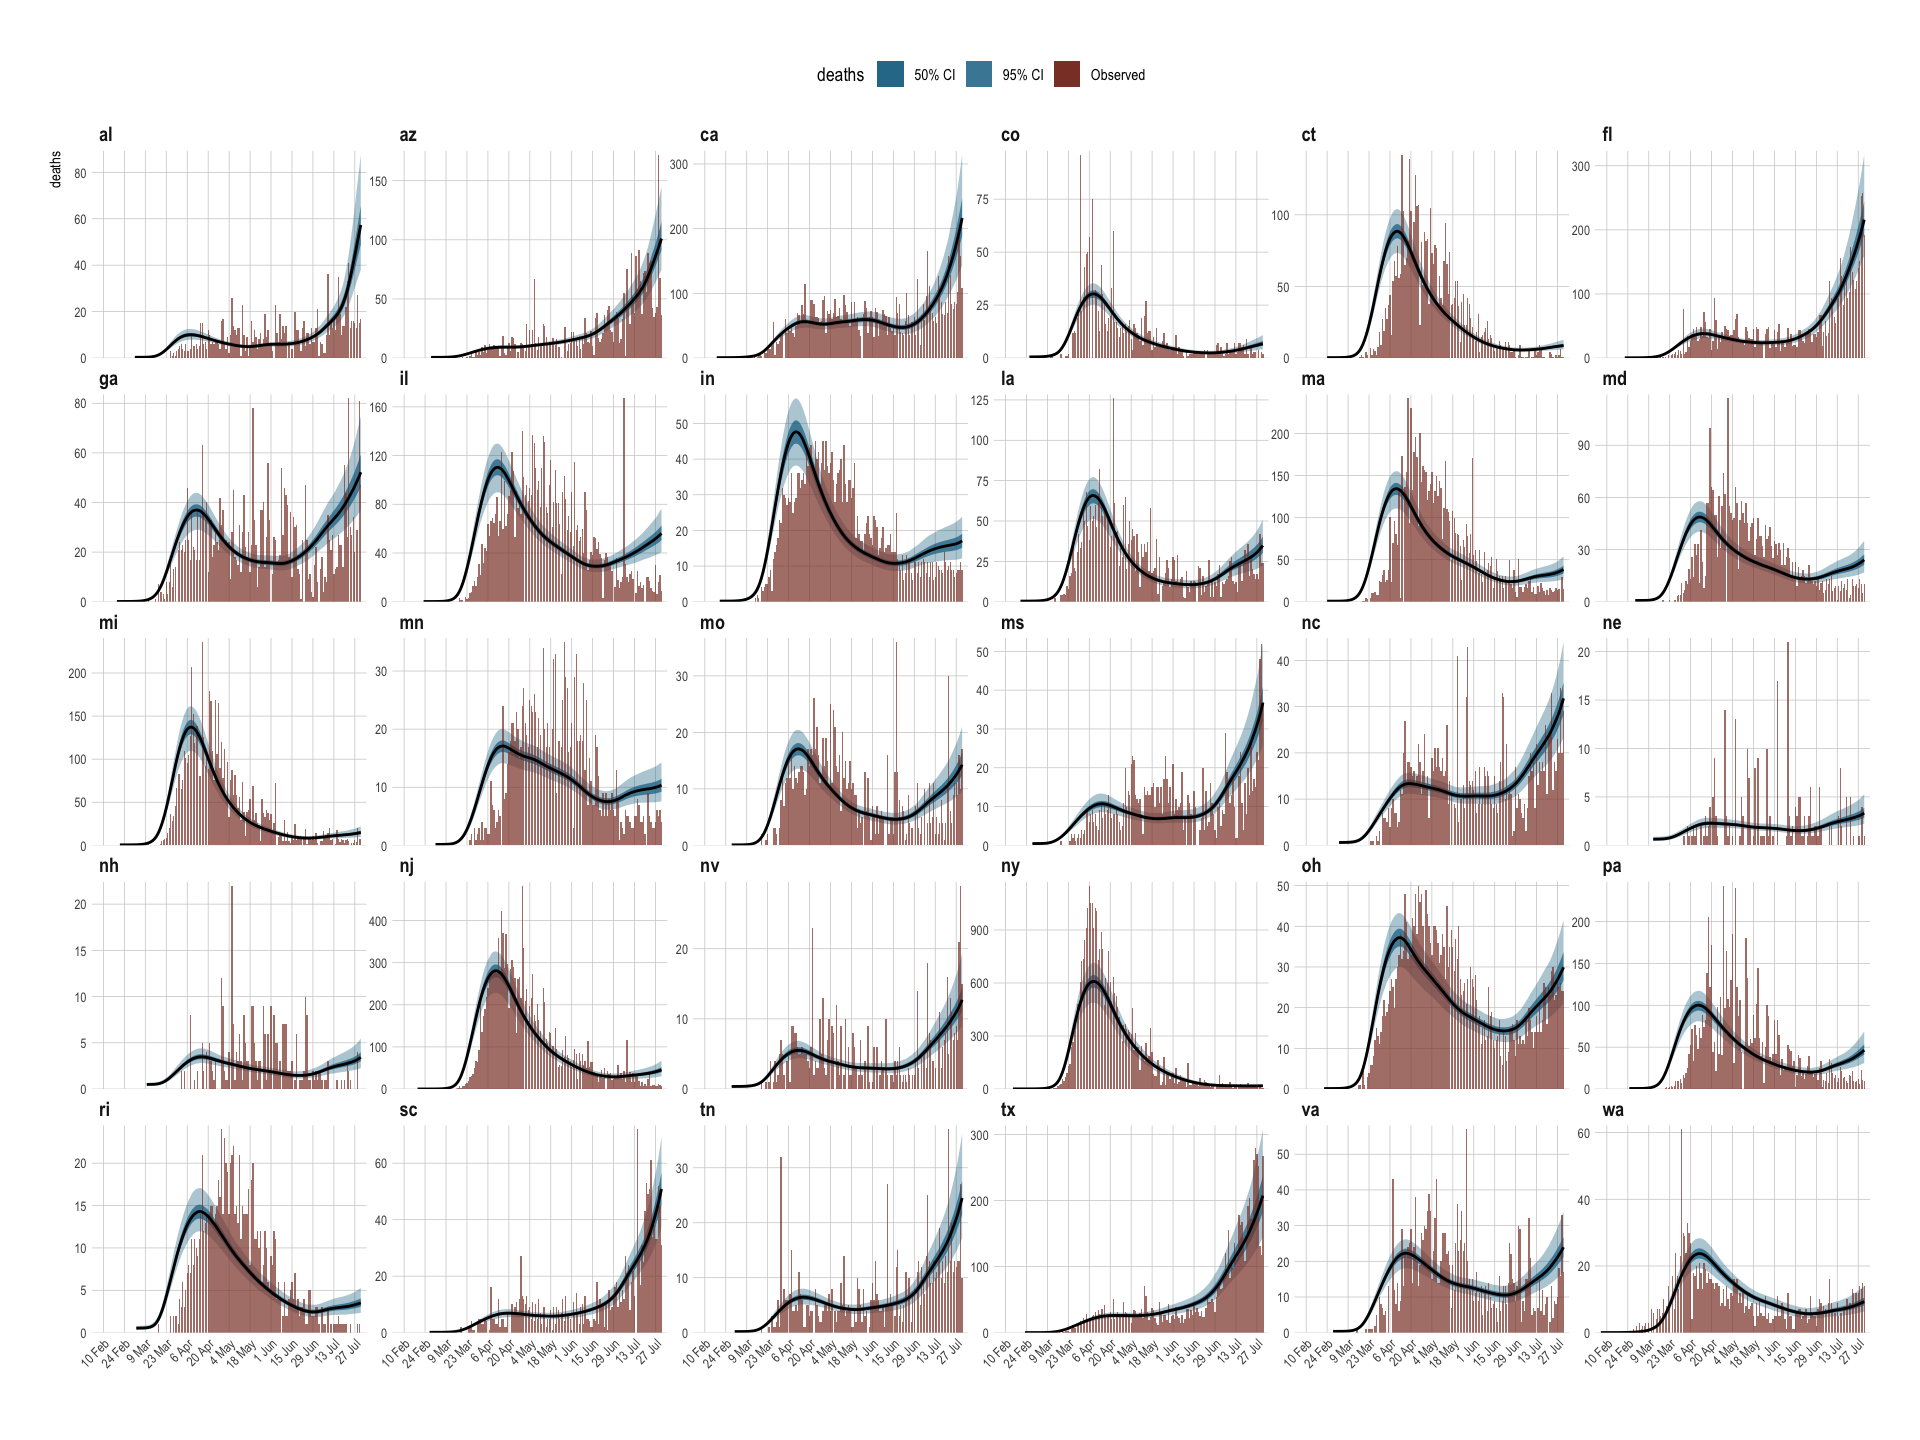

In [53]:
options(repr.plot.width = 16, repr.plot.height = 12)
plot_obs(fm, type="deaths", levels = c(50, 95), posterior_mean=TRUE)

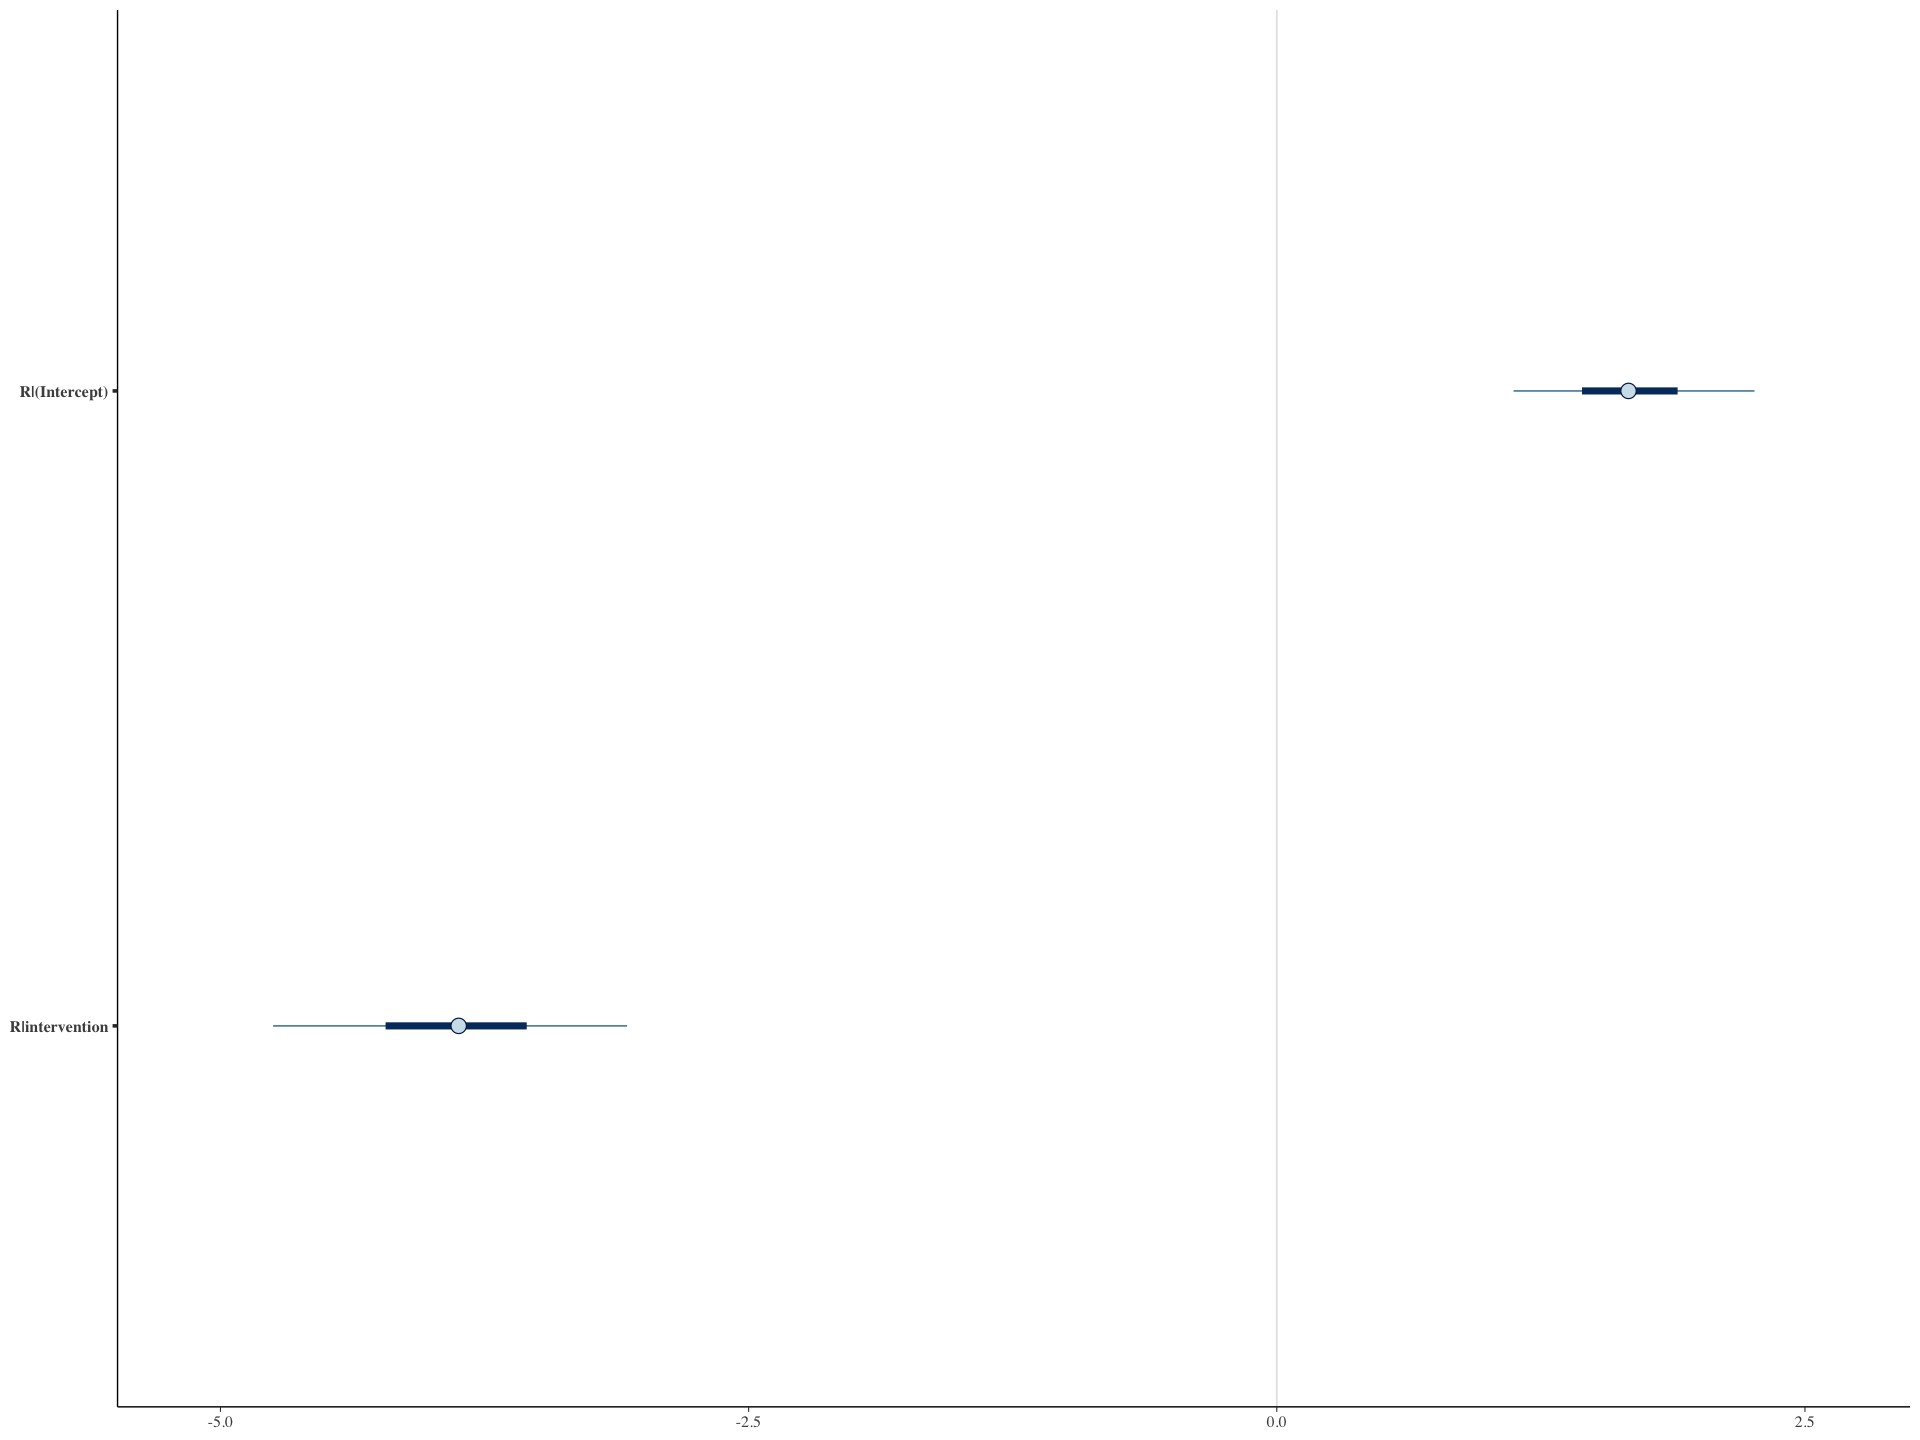

In [54]:
plot(fm, par_models = "R", par_types = "fixed")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


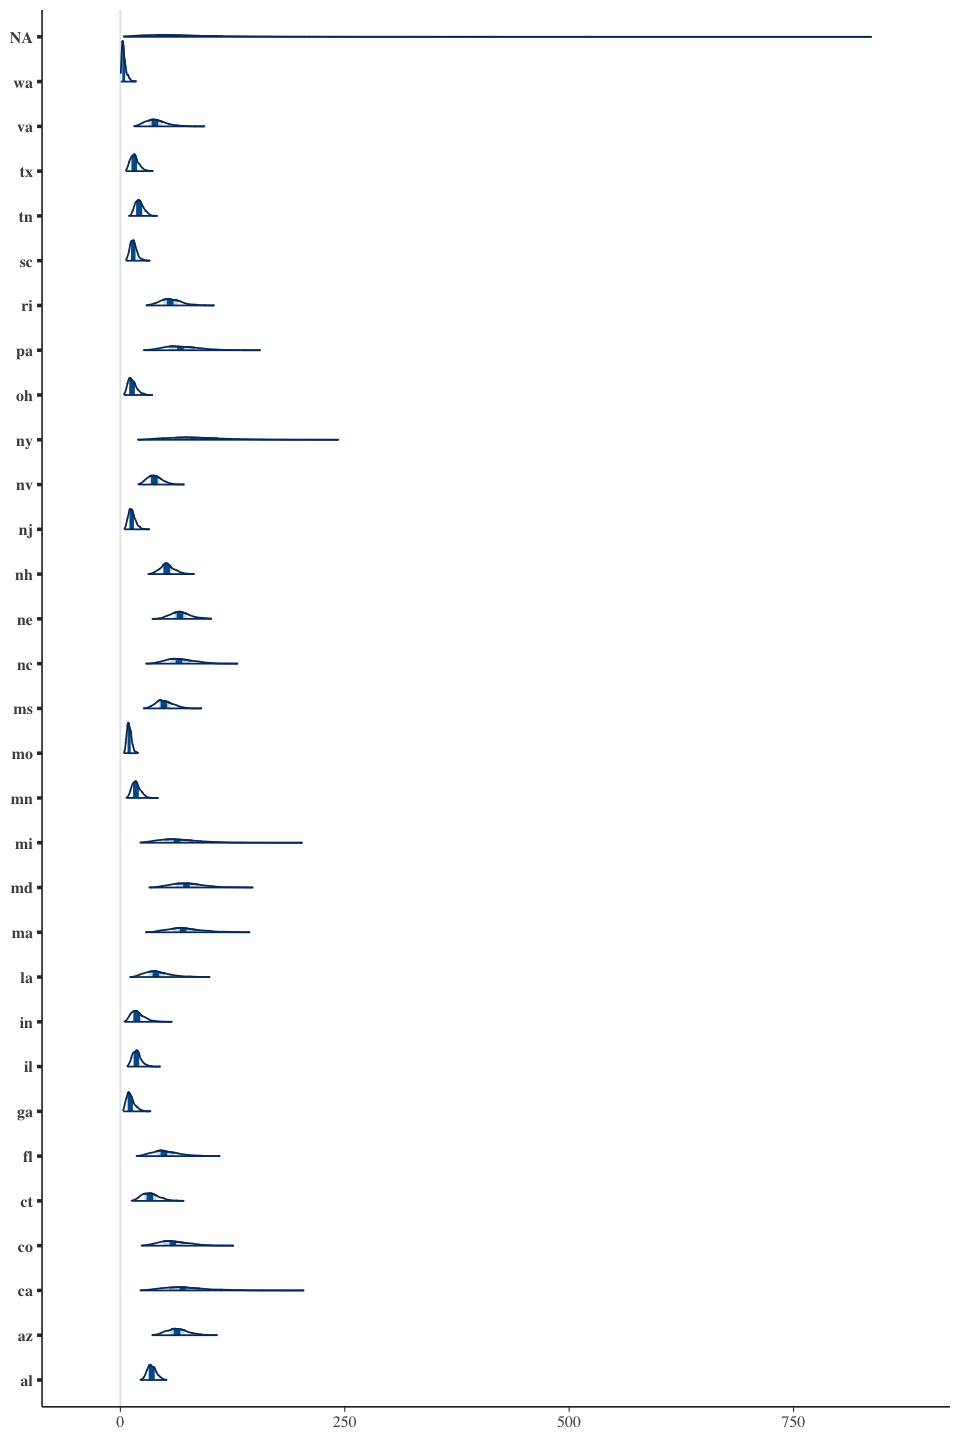

In [55]:
options(repr.plot.width = 8, repr.plot.height = 12)
plot(fm, "areas", regex_pars = "seeds", par_groups = fm$groups) + scale_y_discrete(labels=fm$groups)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


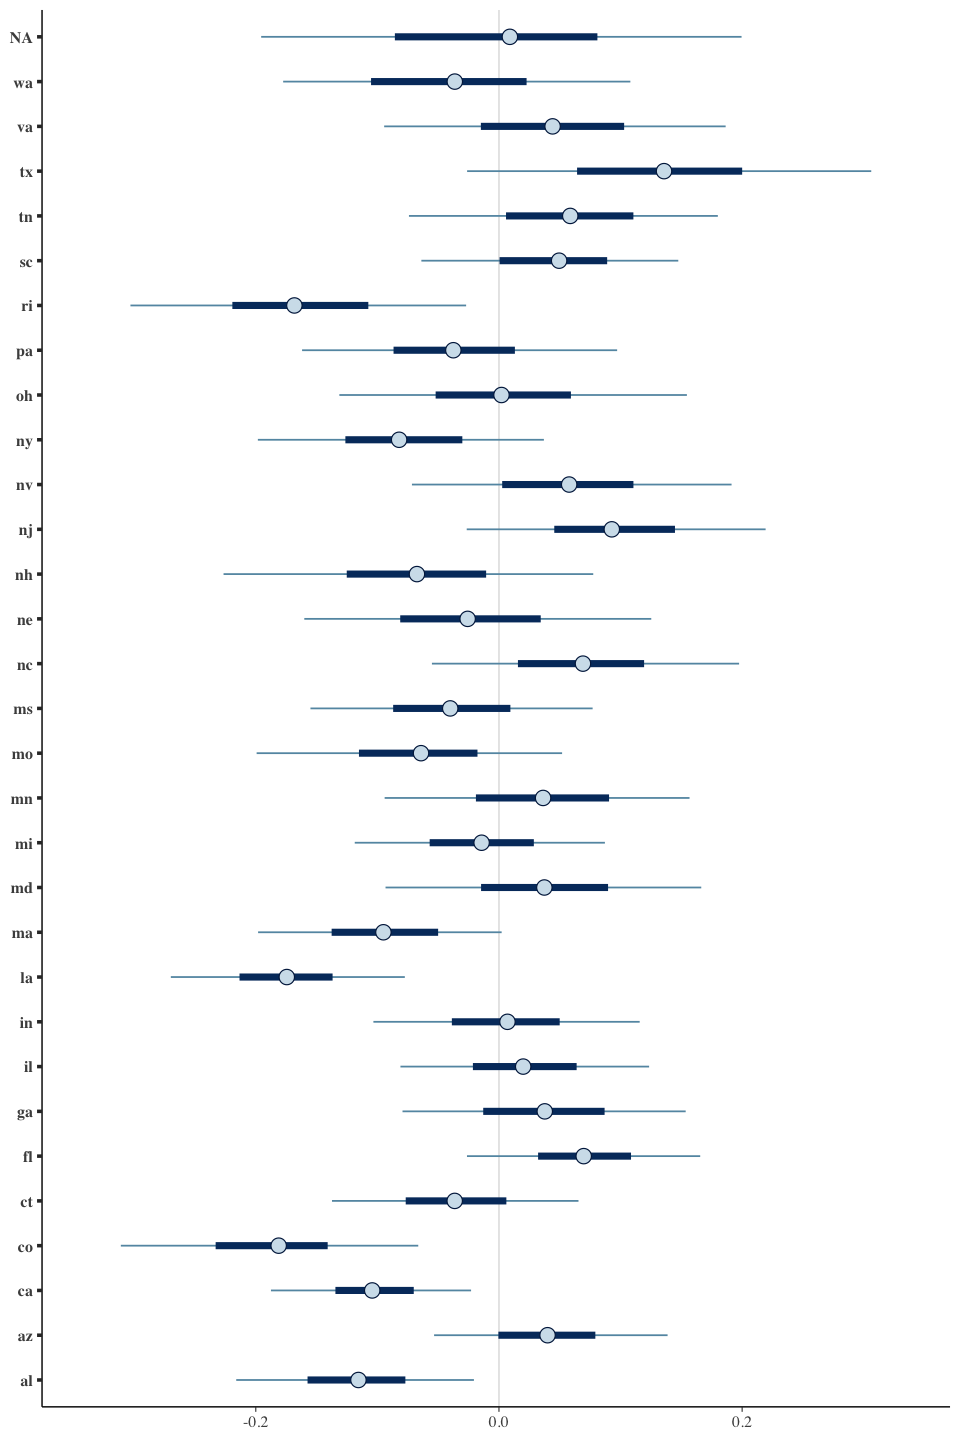

In [56]:
options(repr.plot.width = 8, repr.plot.height = 12)

# beta <- as.matrix(fm, regex_pars = "R\\|\\(Int")
b <- as.matrix(fm, regex_pars = "R\\|b\\[\\(Int")
# mat <- sweep(b, MARGIN=1, STATS = beta, FUN = "+")

bayesplot::mcmc_intervals(b) + scale_y_discrete(labels=fm$groups)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


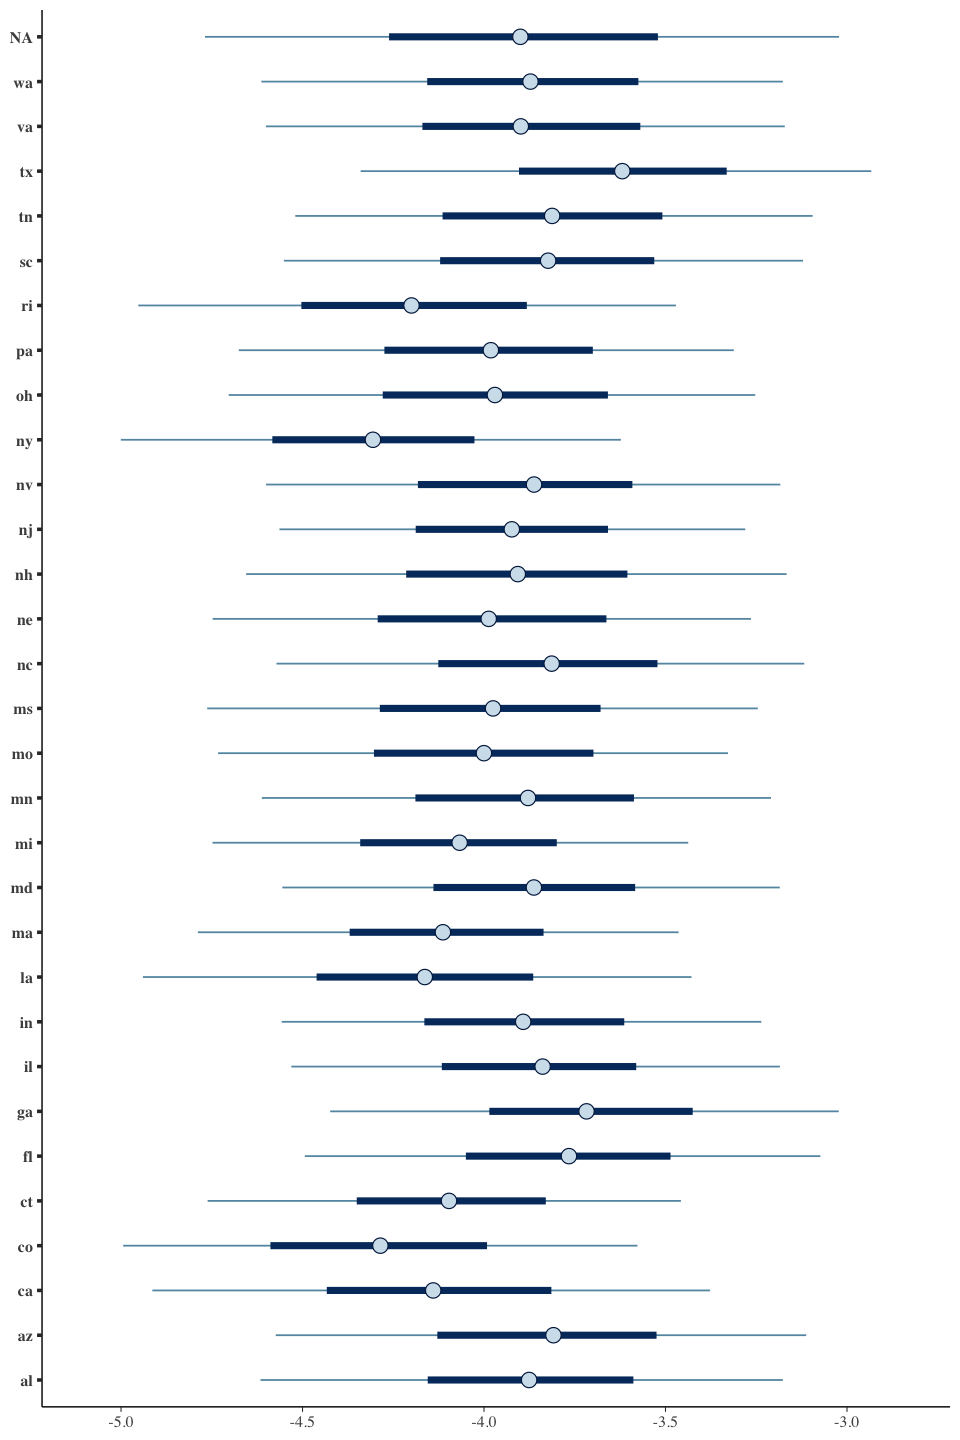

In [57]:
options(repr.plot.width = 8, repr.plot.height = 12)

beta <- as.matrix(fm, regex_pars = "R\\|int")
b <- as.matrix(fm, regex_pars = "R\\|b\\[int")
mat <- sweep(b, MARGIN=1, STATS = beta, FUN = "+")

bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

# 4. Counterfactuals

In [58]:
data_i = data %>% filter(region == 'ny')

In [59]:
A = data_i$intervention
T = length(A)

In [60]:
Tf = 60
Af_dec = rev(A)[1:Tf]*(1 + seq(0,0.2,length=Tf))
Af_inc = A[(T-Tf+1):T]+A[T]-A[T-Tf]

In [61]:
newdata_i = data.frame(
    region = rep('ny',T+Tf),
    date = c(data_i$date, max(data_i$date)+seq(Tf)),
    deaths = c(data_i$deaths, rep(NA,Tf)),
    intervention = c(A,Af_inc))

In [62]:
newdata_dec = data %>% group_modify(~ {
    data.frame(date = c(.x$date, max(.x$date)+seq(Tf)),
               deaths = c(.x$deaths, rep(0,Tf)),
               intervention = c(.x$intervention, rev(.x$intervention)[1:Tf]
                                *(1+seq(0,0.2,length=Tf)))
)})

In [63]:
newdata_inc = data %>% group_modify(~ {
    data.frame(date = c(.x$date, max(.x$date)+seq(Tf)),
               deaths = c(.x$deaths, rep(0,Tf)),
               intervention = c(.x$intervention, 
                                .x$intervention[(length(.x$date)-Tf+1):length(.x$date)]
                                +.x$intervention[length(.x$date)]-.x$intervention[length(.x$date)-Tf])
)})

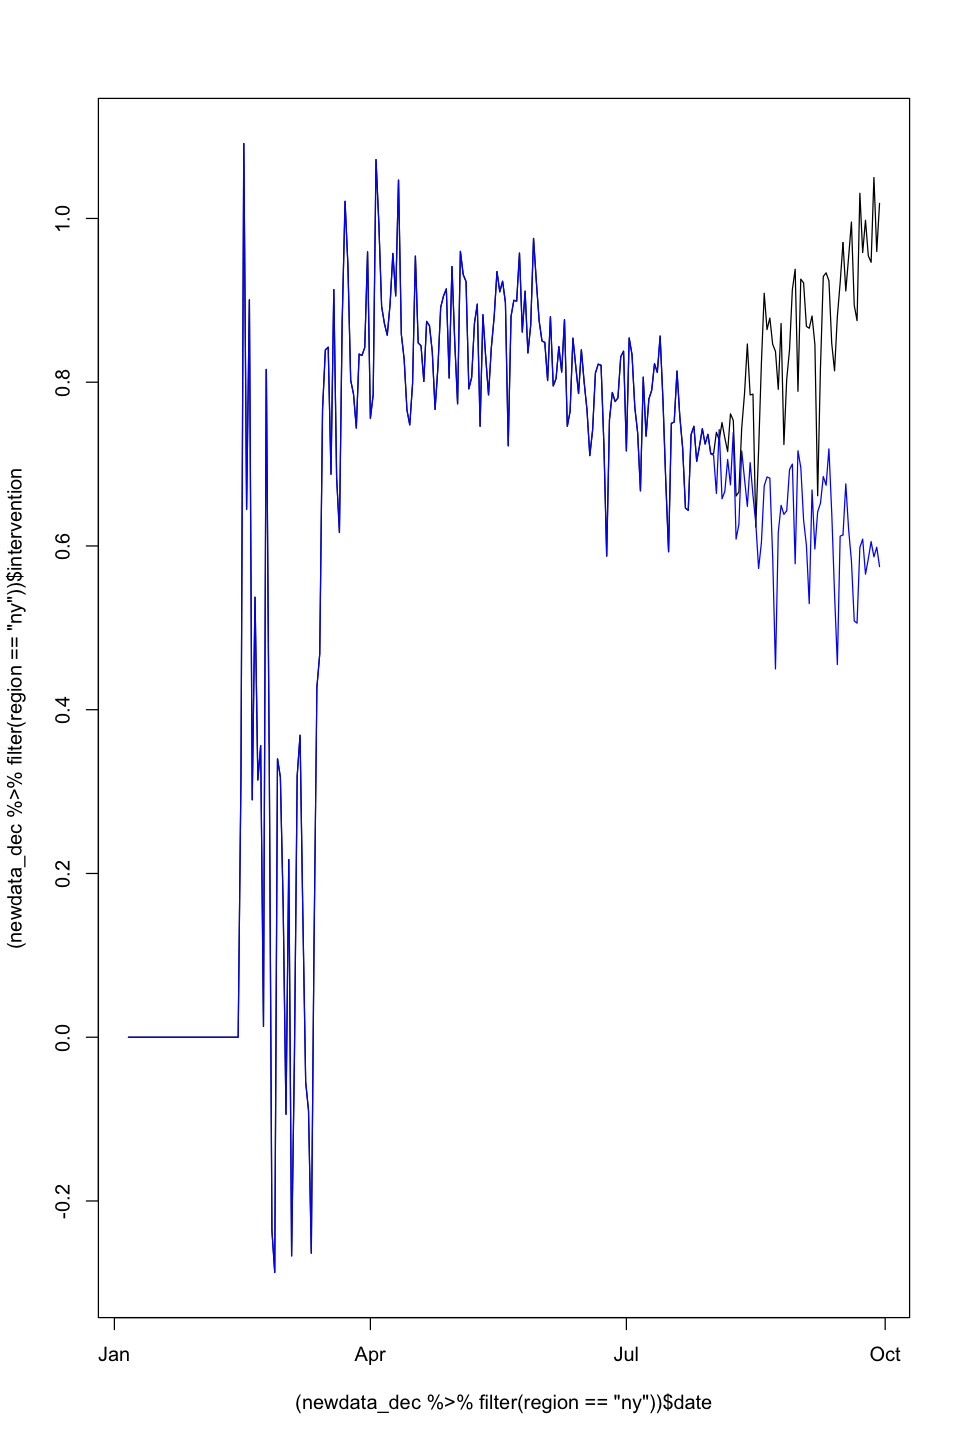

In [64]:
plot((newdata_dec %>% filter(region == 'ny'))$date,
     (newdata_dec %>% filter(region == 'ny'))$intervention, type='l')
lines((newdata_inc %>% filter(region == 'ny'))$date,
      (newdata_inc %>% filter(region == 'ny'))$intervention, col='blue')

In [65]:
obs_dec = posterior_predict(fm, type="deaths", newdata=newdata_dec, posterior_mean=TRUE)

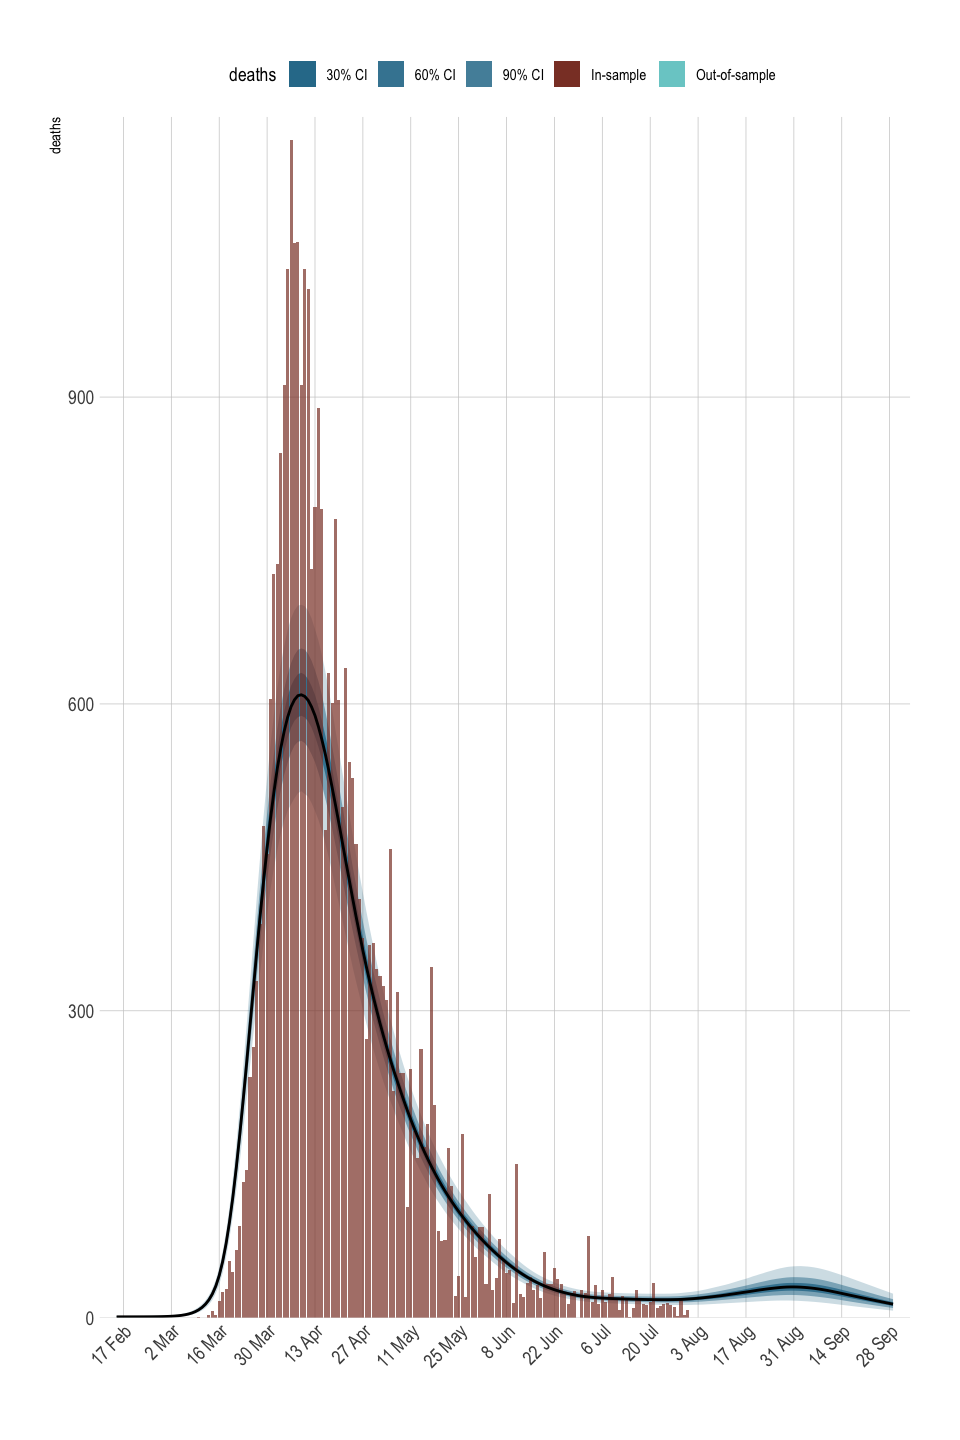

In [66]:
plot_obs(fm, type="deaths", newdata=newdata_dec, posterior_mean=TRUE, groups='ny')

In [67]:
write_feather(data.frame(
    EY = t(obs_dec$draws[,obs_dec$group=='ny'])
), 'counterfactual_epidemia_normal_ny_dec.feather')

In [68]:
obs_inc = posterior_predict(fm, type="deaths", newdata=newdata_inc, posterior_mean=TRUE)

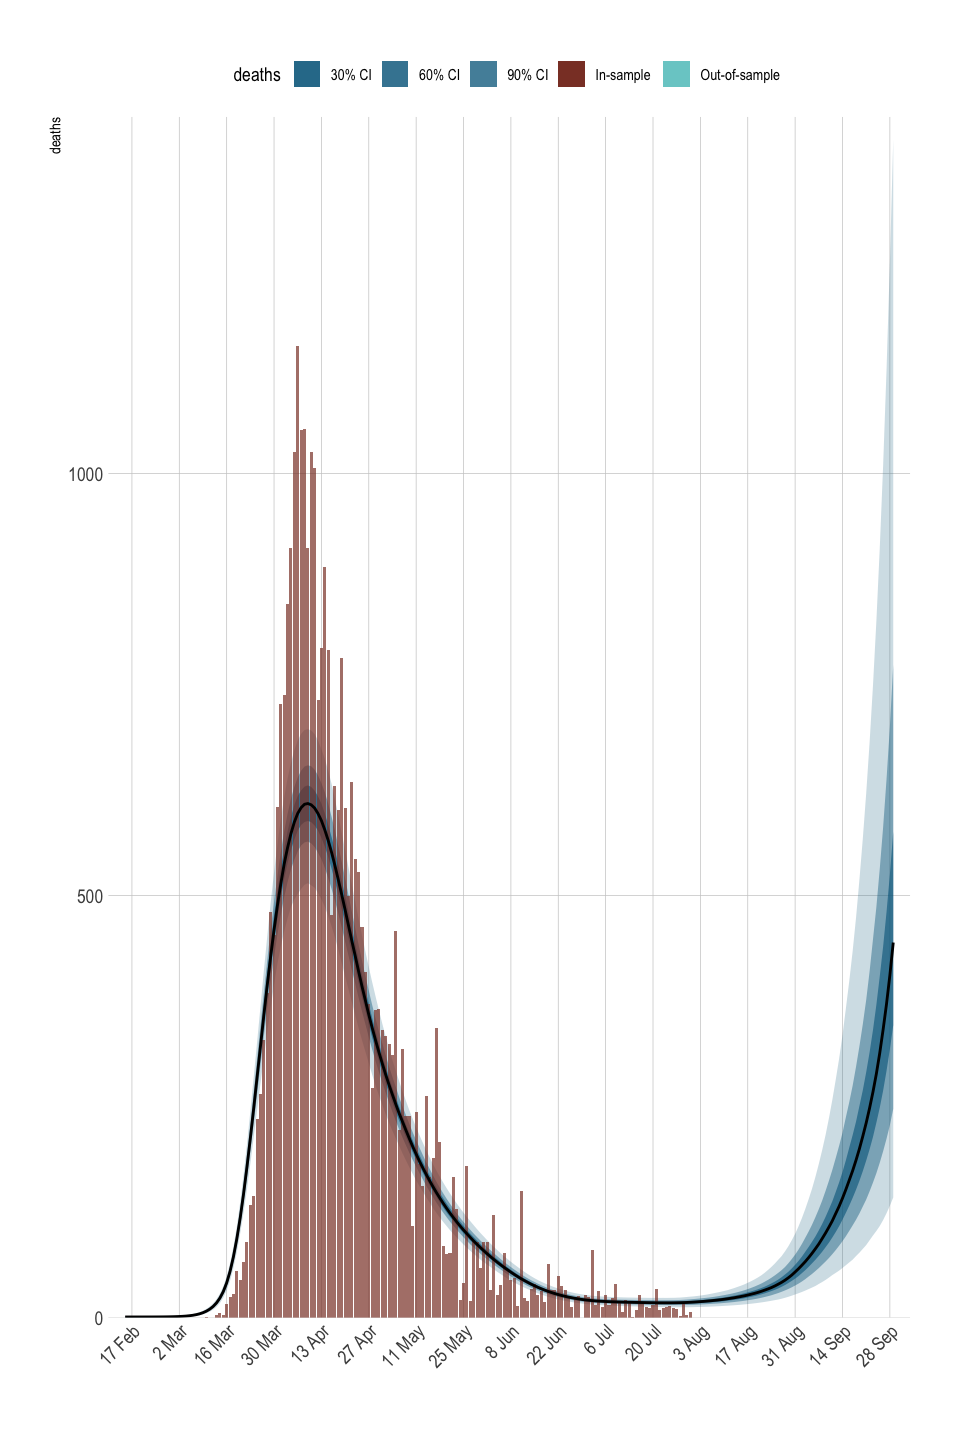

In [69]:
plot_obs(fm, type="deaths", newdata=newdata_inc, posterior_mean=TRUE, groups='ny')

In [70]:
write_feather(data.frame(
    EY = t(obs_inc$draws[,obs_dec$group=='ny'])
), 'counterfactual_epidemia_normal_ny_inc.feather')